In [151]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import LabelEncoder

In [152]:
# Data simulation 
np.random.seed(42) # Ensuring same sequence of numbers being generated 

# Data frame to represent students
fields = ['Artificial Intelligence', 'Computer Science','Software Engineering','Electrical Engineering','Business Analytics']
batches = [19,20,21,22]
room_capacities = [25, 30, 30, 35]

# Students data 
students = pd.DataFrame ({'Student_ID': range(2450), 
                          'Field':np.random.choice(fields,2450),
                          'Batch':np.random.choice(batches,2450)})

# Rooms data 
rooms = pd.DataFrame({'Room_ID':range(1,31),
                      'Capacity':np.random.choice(room_capacities,30) })

# Faculty data 
faculty = pd.DataFrame({'Faculty_ID':range(1,51),
                        'Expertise':np.random.choice (fields,50)})

# Encoding categorical data
le_domain = LabelEncoder()
students['Field_Code'] = le_domain.fit_transform(students['Field'])

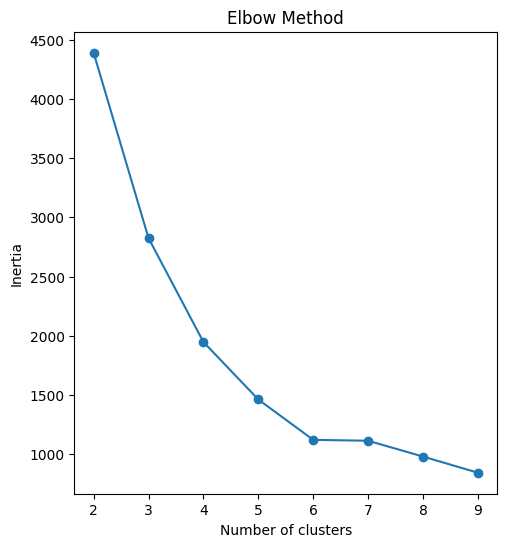

In [153]:
# KMeans Clustering 
# Wei will use elbow method 

X = students[['Field_Code','Batch']]
inertia = [] # it will store the total sum of the squared distances of samples to their nearest cluster center 
for k in range(2,10):
    kmeans = KMeans (n_clusters = k, random_state= 42)
    kmeans .fit (X)
    inertia.append(kmeans.inertia_) # Calculates inertia the lower, the better 

# Plotting 
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
students['Cluster'] = kmeans.fit_predict(X)

In [154]:
# Grouping students and assigning rooms 
cluster_ids = students['Cluster'].unique()
seating_plan = {room.Room_ID:[]for room in rooms.itertuples()} # dictionary comprehension 

for cluster_id in cluster_ids:
    cluster_students = students[students['Cluster']== cluster_id] # includes students only from the current clusters 
    for room in rooms.itertuples(): # further iterate over each room 
        if len(seating_plan[room.Room_ID]) < room.Capacity: # Check the capacity of the roo
            capacity_left = room.Capacity - len(seating_plan[room.Room_ID]) # Calculate the remaining capacity 
            assigned_students = cluster_students.head(capacity_left).Student_ID.tolist() # Assign the rooms to the students 
            seating_plan[room.Room_ID].extend(assigned_students) # Upfate the seating plan 
            cluster_students = cluster_students.iloc[len(assigned_students):] # Removed the students from the cluster who have been assigned 
        if cluster_students.empty: # This will exit when there are no more students 
            break

In [155]:
faculty['Assigned'] = False

# Initialize faculty allocation dictionary and a list for report data
faculty_allocation = {}
report_data = []

# Assign faculty to rooms based on domain expertise
for room_id, student_ids in seating_plan.items():
    if not student_ids:
        continue
    field_most_needed = students.loc[students['Student_ID'].isin(student_ids), 'Field'].mode()[0]
    eligible_faculty = faculty[(faculty['Expertise'] == field_most_needed) & (faculty['Assigned'] == False)].head(1)
    if not eligible_faculty.empty:
        assigned_faculty = eligible_faculty.iloc[0]
        faculty_allocation[room_id] = assigned_faculty['Faculty_ID']
        # Mark the faculty as assigned
        faculty.loc[faculty['Faculty_ID'] == assigned_faculty['Faculty_ID'], 'Assigned'] = True
    else:
        faculty_allocation[room_id] = None  # Assign None if no eligible faculty

# Generate a detailed report for each room
report_columns = ['Room_ID', 'Assigned Students', 'Assigned Faculty', 'Expertise']
for room_id in seating_plan:
    assigned_students = seating_plan[room_id]
    assigned_faculty_id = faculty_allocation.get(room_id, 'No faculty assigned')
    if assigned_faculty_id != 'No faculty assigned' and not faculty[faculty['Faculty_ID'] == assigned_faculty_id].empty:
        faculty_domain = faculty[faculty['Faculty_ID'] == assigned_faculty_id]['Expertise'].iloc[0]
    else:
        faculty_domain = 'None'
    report_data.append([room_id, assigned_students, assigned_faculty_id, faculty_domain])

report_df = pd.DataFrame(report_data, columns=report_columns)

# Save to CSV
csv_file_path = 'exam_seating_faculty_report.csv'
report_df.to_csv(csv_file_path, index=False)

print(f"Report has been saved to {csv_file_path}")

Report has been saved to exam_seating_faculty_report.csv


InvalidIndexError: (array([False, False, False, ..., False, False, False]), 0)

<Figure size 1000x600 with 0 Axes>